## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [0]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from sklearn.preprocessing import OneHotEncoder

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [0]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

(1000, 2)
(1000, 2)


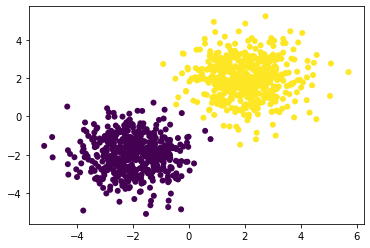

In [5]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')
print(X.shape)
print(Y.shape)

Define a **logistic regression** for debugging. 

In [6]:
net_elu = Sequential()
net_elu.add(Linear(784, 784))
net_elu.add(ELU())
net_elu.add(Linear(784, 784))
net_elu.add(LogSoftMax())
print(net_elu)
# Test something like that then 

net_elu_norm = Sequential()
net_elu_norm.add(Linear(784, 4))
net_elu_norm.add(BatchNormalization())
net_elu_norm.add(ChannelwiseScaling(4))
net_elu_norm.add(ELU())
net_elu_norm.add(Linear(4, 784))
net_elu_norm.add(LogSoftMax())
print(net_elu_norm)

net_softplus = Sequential()
net_softplus.add(Linear(784, 784))
net_softplus.add(SoftPlus())
net_softplus.add(Linear(784, 784))
net_softplus.add(LogSoftMax())
print(net_softplus)

criterion = ClassNLLCriterion()

net_softplus_norm = Sequential()
net_softplus_norm.add(Linear(784, 4))
net_softplus_norm.add(BatchNormalization())
net_softplus.add(ChannelwiseScaling(4))
net_softplus_norm.add(ELU())
net_softplus_norm.add(Linear(4, 784))
net_softplus_norm.add(LogSoftMax())
print(net_softplus_norm)


net_leakyrelu = Sequential()
net_leakyrelu.add(Linear(784, 784))
net_leakyrelu.add(LeakyReLU())
net_leakyrelu.add(Linear(784, 784))
net_leakyrelu.add(LogSoftMax())
print(net_leakyrelu)

net_leakyrelu_norm = Sequential()
net_leakyrelu_norm.add(Linear(784, 4))
net_leakyrelu_norm.add(BatchNormalization())
net_leakyrelu_norm.add(ChannelwiseScaling(4))
net_leakyrelu_norm.add(ELU())
net_leakyrelu_norm.add(Linear(4, 784))
net_leakyrelu_norm.add(LogSoftMax())
print(net_leakyrelu_norm)


net_relu = Sequential()
net_relu.add(Linear(784, 784))
net_relu.add(ReLU())
net_relu.add(Linear(784, 784))
net_relu.add(LogSoftMax())
print(net_relu)


net_relu_norm = Sequential()
net_relu_norm.add(Linear(784, 4))
net_relu_norm.add(BatchNormalization())
net_relu_norm.add(ChannelwiseScaling(4))
net_relu_norm.add(ELU())
net_relu_norm.add(Linear(4, 784))
net_relu_norm.add(LogSoftMax())
print(net_relu_norm)

Linear 784 -> 784
ELU
Linear 784 -> 784
LogSoftMax

Linear 784 -> 4
BatchNormalization
ChannelwiseScaling
ELU
Linear 4 -> 784
LogSoftMax

Linear 784 -> 784
SoftPlus
Linear 784 -> 784
LogSoftMax

Linear 784 -> 4
BatchNormalization
ELU
Linear 4 -> 784
LogSoftMax

Linear 784 -> 784
LeakyReLU
Linear 784 -> 784
LogSoftMax

Linear 784 -> 4
BatchNormalization
ChannelwiseScaling
ELU
Linear 4 -> 784
LogSoftMax

Linear 784 -> 784
ReLU
Linear 784 -> 784
LogSoftMax

Linear 784 -> 4
BatchNormalization
ChannelwiseScaling
ELU
Linear 4 -> 784
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [0]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 1000

In [0]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

In [9]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        print(x_batch.shape, y_batch.shape)
        net_relu.zeroGradParameters()
        
        # Forward
        predictions = net_relu.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net_relu.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net_relu.getParameters(), 
                     net_relu.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

(1000, 2) (1000, 2)


ValueError: ignored

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [10]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [11]:
print(X_train.shape, X_val.shape, X_test.shape)

(50000, 28, 28) (10000, 28, 28) (10000, 28, 28)


In [12]:
print(y_train.shape, y_val.shape, y_test.shape)
print(y_train)
print(y_train.max())

(50000,) (10000,) (10000,)
[5 0 4 ... 8 4 8]
9


In [13]:
print(X)
print(Y)

[[ 2.85089387  2.08246953]
 [ 1.8572472   1.97877855]
 [ 1.9800378   2.27458938]
 ...
 [-2.03577887 -2.04443448]
 [-3.59372281 -2.25550065]
 [-3.03047158 -1.97014048]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


One-hot encode the labels first.

In [0]:
# Your code goes here. ################################################
def one_hot_encode(labels):
    one_hot_encoding = []
    classes_num = 28 
    for label in labels:
        one_hot_vector = np.zeros(shape=(classes_num, classes_num)).tolist()
        one_hot_vector[label][label] = 1
        # print(one_hot_vector)
        one_hot_encoding.append(one_hot_vector)
    return np.array(one_hot_encoding)

In [0]:
y_train = one_hot_encode(y_train)
y_val = one_hot_encode(y_val)
y_test = one_hot_encode(y_test)

In [16]:
print(X_train.shape, y_train.shape)

(50000, 28, 28) (50000, 28, 28)


In [0]:
# Reshape arrays to fit under our training loop
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)


In [18]:
# Test shapes
print(X_train.shape, y_train.shape)

(50000, 784) (50000, 784)


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

Let's write the training loop and plot showing function from above.

In [0]:
def train_and_draw_loss(model, X, Y, criterion = criterion, optimizer=sgd_momentum, n_epoch=100):
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, Y), 50000):
            model.zeroGradParameters()
        
            # Forward
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
    
            # Backward
            dp = criterion.backward(predictions, y_batch)
            model.backward(x_batch, dp)
        
            # Update weights
            optimizer(model.getParameters(), 
                        model.getGradParameters(), 
                        optimizer_config,
                        optimizer_state)      
        
            loss_history.append(loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        
        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()
    
        print('Current loss: %f' % loss)    

Let's check the relu model with different activation functions without any dropout and batch normalization.

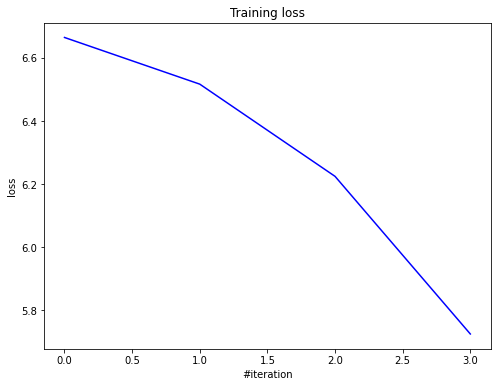

Current loss: 5.724986


In [0]:
# Your code goes here. ################################################
train_and_draw_loss(net_relu, X_train, y_train)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

From above we can see that on this dataset SGD performs better than ADAM, but in more complex datasets ADAM performs better

The loss is around 0.5 => the net is adequate

In [0]:
# Your answer goes here. ################################################
def train_and_draw_time_and_loss(models, X, Y, criterion = criterion, optimizer=sgd_momentum, n_epoch=10):
    opt_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
    activation_functions = [ReLU, LeakyReLU]
    epoch_times = {
               ReLU: [],
               LeakyReLU: [],
              }
    stats_without_bn = {
        ReLU: {},
        LeakyReLU: {},
    }
    batch_size = 128
    for activation_function in activation_functions:
      optimizer_state = {}
      loss_history = []
      for i in range(n_epoch):
        start_time = time()
        total_loss = 0
        for x_batch, y_batch in get_batches((X, Y), batch_size):
            models[activation_function].zeroGradParameters()

            # Forward
            predictions = models[activation_function].forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            total_loss += loss
            # Backward
            dp = criterion.backward(predictions, y_batch)
            models[activation_function].backward(x_batch, dp)
        
            # Update weights
            optimizer(models[activation_function].getParameters(), 
                        models[activation_function].getGradParameters(), 
                        optimizer_config,
                        optimizer_state)      
        end_time = time()
        loss_history.append(total_loss/Y.shape[0])
        epoch_times[activation_function].append(end_time - start_time)
      
      # Visualize
      plt.plot(np.log(loss_history), label = str(activation_functions))
      stats_without_bn[activation_function]['losses'] = loss_history
      stats_without_bn[activation_function]['epoch_times'] = epoch_times
    plt.legend()
    plt.title('Activation functions loss convergence')
    plt.xlabel('epoch number')
    plt.y_label('logloss')
    plt.show()
    for key, value in epoch_times.items():
        print("{}: mean epoch time is {}".format(key, np.mean(value)))
       

In [0]:
plt.figure(figsize=(15,10))
models = {
    ReLU: net_relu,
    LeakyReLU: net_leakyrelu,
    # SoftPlus: net_softplus,
    # ELU: net_elu,
}

train_and_draw_time_and_loss(models, X_train, y_train)

In [0]:
plt.figure(figsize=(15,10))
models = {
    ReLU: net_relu_norm,
    LeakyReLU: net_leakyrelu_norm,
}

train_and_draw_time_and_loss(models, X_train, y_train)

If it's needed, we can just add models in our "models" variable and see all the plots

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [0]:
# Your code goes here. ################################################
#  Ideal model initialization
net = net = Sequential()
net.add(Linear(X_train.shape[1], 384))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(384))
net.add(LeakyReLU())        
net.add(Linear(384, 192))
net.add(Dropout())
net.add(ReLU())
net.add(Linear(192, y_train.shape[1]))
net.add(LogSoftMax())

In [0]:
opt_config = {'learning_rate': 3e-4, 'beta1': 0.9, 'beta2':0.95, 'epsilon':1e-9}
batch_size = 128
n_epoch = 6
optimizer_state = {}
val_accuracy = {}
losses = {
    'train': [],
    'val': [],
}
times = []

In [0]:
for i in range(n_epoch):
    ep_v_a = []
    start = time()
    loss_sum = 0.0
    for X_batch, y_batch in get_batches((X_train, y_train), batch_size):
        net.zeroGradParameters()
        predicted = net.forward(X_batch)
        loss = criterion.forward(predicted, y_batch)
        loss_sum += loss
        dp = criterion.backward(predicted, y_batch)
        net.backward(X_batch, dp)
        adam_optimizer(net.getParameters(), 
                     net.getGradParameters(), 
                     opt_config,
                     optimizer_state)      
    end = time()
    times.append(end - start)
    losses['train'].append(total_loss / X.shape[0])
    total_loss = 0
    for X_batch, y_batch in get_batches((X_val, y_val), batch_size):
        net.zeroGradParameters()
        predicted = net.forward(X_batch)
        loss = criterion.forward(predicted, y_batch)
        loss_sum += loss  
        ep_v_a.append(np.mean(y_batch == predicted))
    
    losses['val'].append(loss_sum / X.shape[0])
    
    loss_sum = 0.0
    for X_batch, y_batch in get_batches((X_test, y_test), batch_size):
        net.zeroGradParameters()
        predicted = net.forward(X_batch)
        loss = criterion.forward(predicted, y_batch)
        loss_sum += loss  
    
    losses['test'].append(loss_sum / X.shape[0])

net.evaluate()
y_pred = np.argmax(net.forward(X_train), axis = 1)
y_true = np.argmax(y_train, axis = 1)
train_accuracy = (y_true == y_pred).mean()    
    
net.evaluate()
y_pred = np.argmax(net.forward(X_test), axis = 1)
y_true = np.argmax(y_test, axis = 1)
test_accuracy = (y_true == y_pred).mean()

net.evaluate()
y_pred = np.argmax(net.forward(X_val), axis = 1)
y_true = np.argmax(y_val, axis = 1)
val_accuracy = (y_true == y_pred).mean()
    
plt.figure(figsize=(16,9))

plt.plot(losses['train'])
plt.plot(losses['val'])
plt.title('Ideal network')
plt.xlabel("epochs num")
plt.ylabel("logloss")
plt.legend(['Train', 'Val'])

plt.show()

print("Train accuracy: {}".format(train_accuracy))
print("Valid accuracy: {}".format(val_accuracy))

TypeError: ignored

Print here your accuracy on test set. It should be around 90%.

In [0]:
# Your answer goes here. ################################################
print("Test dataset accuracy: {}".format(test_accuracy))

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [0]:
# Your beautiful code here.
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import datasets, transforms
from torch import nn
from torch.nn import functional as F
import os
from torchsummary import summary

def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'mnist'
mkdir(root_path)

Directory mnist is created!


In [0]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root_path, train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ])),
        batch_size=128, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root_path, train=False, transform=transforms.Compose([
                           transforms.ToTensor()
                       ])),
        batch_size=256, shuffle=True, num_workers=2)

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw




Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
loss_func = nn.NLLLoss()

model = nn.Sequential(nn.Flatten(),
                     nn.Linear(28*28, 392), 
                     nn.BatchNorm1d(392), 
                     nn.ReLU(), 
                     nn.Linear(392, 196), 
                     nn.BatchNorm1d(196),
                     nn.ReLU(),
                     nn.Dropout(p=0.2),
                     nn.Linear(196, 10))

opt = torch.optim.Adam(model.parameters(), lr=3e-5)

In [0]:
def train(model, train_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    test_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_test_accuracy = []
        start_time = time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
            
                preds = model(X_batch)
                loss = loss_fn(preds, y_batch)
                
                ep_val_loss.append(loss.item())
                y_pred = preds.max(1)[1].data
                ep_test_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy()))

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        test_accuracy.append(np.mean(ep_test_accuracy))

    return train_loss, val_loss, test_accuracy

In [0]:
train_loss, val_loss, torch_accuracy = train(model, train_loader, loss_func, opt, 6)

In [0]:
print(torch_accuracy)

[0.85576171875, 0.8939453125, 0.91474609375, 0.9208984375, 0.9279296875, 0.9345703125]


In [0]:
print("Accuracy of pytorch model : {:.5}".format(np.mean(torch_test_accuracy)))

Accuracy of pytorch model : 0.90798


## Conclusion
We got that the Pytorch results are better than ours,  but our written model also shows great results